In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.trigger import recursive_sta_lta, plot_trigger, trigger_onset

import itertools
import pyrocko
from pyrocko import obspy_compat
obspy_compat.plant()

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

/home/nivkeren/anaconda3/envs/work_env/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


In [2]:
AVG_EARTH_RADIUS_KM = 6371.0088

# Module that download waveforms
def download_event_waveforms(client, t0, t1, networks="*", stations="*", locations="*", channels="*"):
    st = client.get_waveforms(network=networks, station=stations, location=locations, channel=channels, starttime=t0, endtime=t1)
    st = st.slice(starttime=t0, endtime=t1)
    st.write(filename=f"{t0}-{t1}.mseed", format="MSEED")
    return st

def haversine(points1, points2):
    """ Calculate the great-circle distance between two points on the Earth surface.
    :inp: two 2-tuples, containing the latitude and longitude of each point
    in decimal degrees.
    Example: haversine((45.7597, 4.8422), (48.8567, 2.3508))
    :output: Returns the distance between the two points in km.
    """
    # get earth radius in required units
    avg_earth_radius = AVG_EARTH_RADIUS_KM

    # unpack latitude/longitude
    lats1, lons1 = points1
    lats2, lons2 = points2

    # convert all latitudes/longitudes from decimal degrees to radians
    lats1, lons1, lats2, lons2 = map(np.radians, (lats1, lons1, lats2, lons2))

    # calculate haversine

    distance = np.arcsin(np.sqrt(
        np.sin((lats2 - lats1) * 0.5) ** 2
        + (np.cos(lats1) * np.cos(lats2) * np.sin((lons2 - lons1) * 0.5) ** 2)))
    return 2 * avg_earth_radius * distance

def bearing(points1, points2):
    
    # unpack latitude/longitude
    lats1, lons1 = points1
    lats2, lons2 = points2
    # convert all latitudes/longitudes from decimal degrees to radians
    lats1, lons1, lats2, lons2 = map(np.radians, (lats1, lons1, lats2, lons2))
    
    # calculate bearing
    dlons = lons2 - lons1
    y = np.sin(dlons) * np.cos(lats2)
    x = np.cos(lats1) * np.sin(lats2) - np.sin(lats1) * np.cos(lats2) * np.cos(dlons)
    return np.arctan2(y, x)

def absolute2relative(points1, points2):
    
    dist = haversine(points1, points2)
    azim = bearing(points1, points2)    
    return dist * np.sin(azim), dist * np.cos(azim)

def conversite(latitudes, longitudes, grid_size=100):
    min_lat = latitudes.min()
    max_lat = latitudes.max()
    
    min_lon = longitudes.min()
    max_lon = longitudes.max()
    
    grid_max = absolute2relative((min_lon, min_lat), (max_lat, max_lon))
    rstations = absolute2relative(np.tile((min_lat, min_lon), (len(latitudes), 1)).T,
                                  (latitudes, longitudes))
    
    return rstations, max(grid_max) / grid_size


In [3]:
isr_fdsn = "http://82.102.143.46:8181"
client = Client(isr_fdsn)#, user='niv.keren@gmail.com', password='fdsnisfun1', timeout=240)

In [4]:
my_events = pd.read_csv("events.csv").sort_values(["event time"])
all_events = pd.read_csv("all_events.csv").set_index('event_time')
waveforms_raw = []
waveforms_detrented = []
waveforms_filtered = []

In [5]:
for idx, event in my_events.iterrows():
    cat_event = all_events.loc[event['event time']]
    my_events.loc[idx, "cat_lat"] = cat_event.lat
    my_events.loc[idx, "cat_lon"] = cat_event.lon
    my_events.loc[idx, "cat_mag"] = cat_event.magnitude
my_events

,event time,cat_lat,cat_lon,cat_mag
0,2018-07-04T01:50:06.667000Z,32.848,35.583,4.797476941 M
2,2018-07-04T01:54:26.532000Z,32.859,35.585,2.552366975 M
3,2018-07-04T03:57:39.993000Z,32.840,35.597,3.288243713 M
1,2018-07-04T19:45:39.428000Z,32.843,35.572,4.761445325 M
4,2018-07-04T19:51:24.449000Z,32.852,35.578,3.821342778 M
5,2018-07-05T04:00:03.956000Z,32.848,35.579,2.975286543 M
6,2018-07-05T16:51:36.987000Z,32.836,35.574,2.957468776 M
7,2018-07-06T05:38:54.227000Z,32.861,35.569,2.760879312 M
8,2018-07-07T02:07:44.383000Z,32.837,35.599,3.993414954 M
9,2018-07-08T12:52:17.385000Z,32.846,35.578,3.099346613 M


In [6]:
day_sec = 24 * 3600
inv_start = UTCDateTime(my_events["event time"].min()) - day_sec
inv_end = UTCDateTime(my_events["event time"].max()) + day_sec

cat_start = UTCDateTime(my_events["event time"].min()) - 1
cat_end = UTCDateTime(my_events["event time"].max()) + 1
networks = 'IS'
stations = ','.join(['MLDT', 'CVYN', 'MNHM', 'SHGL', 'ALMT', 'GLHS', 'ENGV', 'TVR', 'MGDL', 'SPR', 'KNHM', 
                'RMOT', 'HDNS', 'AMID', 'ZEFT', 'RSPN', 'KSHO', 'KDZV', 'HULT', 'ZRT'])
channels = str([''.join(ch) for ch in itertools.product("BHSE", "LHN", "?")])[1:-1].replace("'", '')
inv = client.get_stations(starttime=inv_start, endtime=inv_end, network=networks, station=stations, channel=channels, level="response")
cat_events = client.get_events(starttime=cat_start, endtime=cat_end,
                               latitude=32.80, longitude=35.60, maxradius=0.4, minmagnitude=2.0, includearrivals=True, includepicks=True)
print(f"strat time: {inv_start}, {cat_start}")
print(f"end time: {inv_end}, {cat_end}")
print(f"network: {networks}")
print(f"stations: {stations}")
print(f"channels: {channels}")
print(cat_events)

strat time: 2018-07-03T01:50:06.667000Z, 2018-07-04T01:50:05.667000Z
end time: 2018-08-09T23:21:09.796000Z, 2018-08-08T23:21:10.796000Z
network: IS
stations: MLDT,CVYN,MNHM,SHGL,ALMT,GLHS,ENGV,TVR,MGDL,SPR,KNHM,RMOT,HDNS,AMID,ZEFT,RSPN,KSHO,KDZV,HULT,ZRT
channels: BL?, BH?, BN?, HL?, HH?, HN?, SL?, SH?, SN?, EL?, EH?, EN?
305 Event(s) in Catalog:
2018-08-08T23:21:09.796000Z | +32.830,  +35.590 | 2.461059054 M  | automatic
2018-08-08T23:21:09.796000Z | +32.830,  +35.590 | 2.246282972 Mws | automatic
...
2018-07-04T01:50:07.218000Z | +32.863,  +35.563 | 4.548712914 M  | automatic
2018-07-04T01:50:06.667000Z | +32.848,  +35.583 | 4.797476941 M  | automatic
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [7]:
catalog = obspy.Catalog()
for event in my_events.iterrows():
#         print(event[1])
    for cat_event in cat_events.events[::-1]:
        origin = cat_event.preferred_origin() or cat_event.origins[-1]
        if origin is None:
            continue
        if event[1]["event time"] == str(origin.time):
            catalog.append(cat_event)
            break
    else:
        print("NO match")
        print(event)
catalog.write("catalog.xml", format="QUAKEML")

In [19]:
for idx, event in my_events.iterrows():
    t = UTCDateTime(event["event time"])
    start_time = t - 5
    end_time = t + 30
    print(f"downloading mseed wavform file from : {start_time} to : {end_time}")
    st = download_event_waveforms(client=client, t0=start_time, t1=end_time, networks="IS", stations=stations, channels=channels)
    st_detrened = st.copy().detrend("linear")
    st_filtered = st_detrened.copy().filter("bandpass", freqmin=1, freqmax=10)
    waveforms_raw.append(st)
    waveforms_detrented.append(st_detrened)
    waveforms_filtered.append(st_filtered)

downloading mseed wavform file from : 2018-07-04T01:50:01.667000Z to : 2018-07-04T01:50:36.667000Z


NameError: name 'waveforms_raw' is not defined

In [8]:
import os
DIR_PATH = '.'
mseed_paths = [os.path.join(DIR_PATH,path) for path in os.listdir(DIR_PATH) 
               if os.path.isfile(path) and path.lower().endswith('.mseed')]
for path in mseed_paths:
    print(f"loading mseed file: {path}")
    st = obspy.read(path, format="MSEED")
    st_detrened = st.copy().detrend("linear")
    st_filtered = st_detrened.copy().filter("bandpass", freqmin=2, freqmax=5)
    waveforms_raw.append(st)
    waveforms_detrented.append(st_detrened)
    waveforms_filtered.append(st_filtered)

### p picking

In [94]:
def distance_from_event(event, points, elevations, local_depths):
    origin = event.preferred_origin() or event.origins[-1]
    hypo_dist = haversine((points), np.tile((origin.latitude, origin.longitude), (points.shape[1], 1)).T)
    depth = (elevations - local_depths + origin.depth) / 1000
    epi_dist = np.sqrt((hypo_dist**2 + depth**2))
    return epi_dist, hypo_dist

def catalog_pick(event, network, station):
    cat_tp = None
    cat_ts= None
    
    for pick in event.picks:
        if (pick.waveform_id.network_code, pick.waveform_id.station_code) == (network, station):
            t = pick.time
            if pick.phase_hint in ('P', 'p'):
                cat_tp = t
            elif pick.phase_hint in ('S', 's'):
                cat_ts = t
    return cat_tp, cat_ts

def sta_lta_pick(tr, sta, lta, thres1, thres2)
    tp_sta = None
    
    sr = tr.stats.sampling_rate
    cft = recursive_sta_lta(tr.data, int(sta * sr), int(lta * sr))
    p = trigger_onset(cft, thres1, thres2, max_len=1)
    if len(p) > 0:
        tp_sta = UTCDateTime((tr.stats.starttime + tr.times()[p[0][0]]).timestamp)  
    return tp_sta

def hand_pick(st, freqmin=1, freqmax=10):   
    tp = None
    ts = None
    
    st_filtered = st_detrened.copy()..detrend("linear").filter("bandpass", freqmin=freqmin, freqmax=freqmax)
    
    for tr_pick in st_filtered:
        tr_pick.stats.location = f"{freqmin}{freqmax}"
    st_pick = st_filtered + st.cpoy()
        
    picks = st_pick.snuffle(inventory=inv)
    for mark in picks[1]:
        mark.get_phasename()
        if mark.get_phasename()=="P":
            tp = UTCDateTime(mark.get_tmin())
        if mark.get_phasename()=="S":
            ts = UTCDateTime(mark.get_tmin())
    return tp, ts

def event_df(st, inv, event):
    cols = ["lat", "lon", "elevation", "local_depth", "sampling_rate", "distance_catalog", "tp_catalog", "ts_catalog", "tp_sta_lta", "tp", "ts"]
    index_cols = ["station", "channel"]
    df = pd.DataFrame(columns=index_cols + cols).set_index(index_cols)
    stz = st.select(component="Z")
    for tr in stz:
        network = tr.stats.network
        station = tr.stats.station
        channel = tr.stats.channel
        sr = tr.stats.sampling_rate
        coord = inv.get_coordinates(f"{network}.{station}.{tr.stats.location}.{channel}",
                                    tr.stats.starttime)
        lat, lon, elevation, local_depth = coord.values()
        st_station = st.select(station=station, channel=channel[0: 2] + '?').sort(reverse=True)
        
        tp_sta = np.nan
        tp = np.nan
        ts = np.nan
        cat_tp = np.nan
        cat_ts = np.nan        
        
        
        epi_dist, hypo_dist = distance_from_event(event, (lat, lon), elevation, local_depth)
        
        #catalog picks
        cat_tp, cat_ts = catalog_pick(event, network, station)
                
        # p pick with sta/lta
        tp_sta = sta_lta_pick(tr, 1, 5, 3, 1)
        
        print(f"distance form hypocenter: {hypo_dist} km")
        print(f"time between p and s waves: {hypo_dist / 8} s")
#         print(f"distance form epicenter: {epi_dist} km")
#         print(f"time between p and s waves: {epi_dist / 8} s")
        print("----")
        tp, ts = hand_pick(st_station)
        # cols = ["lat", "lon", "elevation", "local_depth", "sampling_rate", "distance_catalog", "tp_catalog", "ts_catalog", "tp_sta_lta", "tp", "ts"]
        df.loc[(station, channel[0: 2]), cols] = lat, lon, elevation, local_depth , sr, hypo_dist, \
                                                 cat_tp, cat_ts, tp_sta, tp, ts
    return df

In [99]:
for i in range(j + 1, len(my_events)):
    df_event = event_df(waveforms_raw[i], waveforms_filtered[i], inv, catalog[i])
    df_event.reset_index().to_csv(f'{my_events.loc[i, "event time"]}.csv')
    j = i
df_event

distance form hypocenter: 18.16366552534139 km
time between p and s waves: 2.2704581906676737 s
----
distance form hypocenter: 18.015348392211614 km
time between p and s waves: 2.2519185490264517 s
----
distance form hypocenter: 8.239661754876682 km
time between p and s waves: 1.0299577193595852 s
----
distance form hypocenter: 6.151680419247032 km
time between p and s waves: 0.768960052405879 s
----
distance form hypocenter: 7.306270929288276 km
time between p and s waves: 0.9132838661610345 s
----
distance form hypocenter: 15.453482022531615 km
time between p and s waves: 1.9316852528164519 s
----
distance form hypocenter: 13.746202015454639 km
time between p and s waves: 1.7182752519318298 s
----
distance form hypocenter: 13.746202015454639 km
time between p and s waves: 1.7182752519318298 s
----
distance form hypocenter: 12.829200132588232 km
time between p and s waves: 1.603650016573529 s
----
distance form hypocenter: 25.359438897203308 km
time between p and s waves: 3.1699298621

lat      lon  elevation  local_depth  sampling_rate  \
station channel                                                            
ZEFT    EN       32.9688  35.4937      803.0          0.0          200.0   
MNHM    EN       32.6636  35.5523     -132.0          0.0          200.0   
RMOT    EN       32.8515  35.6645       12.0          0.0          200.0   
SPR     EN       32.8647  35.5388     -177.0          0.0          200.0   
MGDL    EN       32.8403  35.5072      -83.0          5.0          200.0   
SHGL    EN       32.6858  35.6043     -166.0          4.0          200.0   
GLHS    HH       32.7134  35.6496      356.0          5.0          200.0   
        EN       32.7134  35.6496      356.0          2.0          200.0   
HDNS    EN        32.928  35.6412        0.0          0.0          200.0   
HULT    EN       33.0504   35.611      117.0          0.0          200.0   
AMID    EN        32.927  35.5393      274.0          6.0          200.0   
RSPN    EN       32.9704  35.5463      376.0          0.0          200.0   
CVYN    EN       32.5954  35.5186      323.0          2.0          200.0   
ENGV    EN       32.7815  35.6385     -172.0          0.0          200.0   
ZRT     EN       33.1015  35.2901      678.0          0.0          200.0   
KNHM    EN       32.8837  35.5792     -174.0          0.0          200.0   
TVR     EN       32.7813  35.5397     -127.0          0.0          200.0   
ALMT    EN        32.708  35.5468       64.0          0.0          200.0   

                  cat_tp cat_ts cat_distance                   tp_sta_lta  \
station channel                                                             
ZEFT    EN       17.8945    NaN          NaN                          NaN   
MNHM    EN       18.8021    NaN          NaN  2018-07-31T01:30:55.290000Z   
RMOT    EN       7.36223    NaN          NaN  2018-07-31T01:30:52.270000Z   
SPR     EN        6.1756    NaN          NaN  2018-07-31T01:30:53.285000Z   
MGDL    EN       7.83481    NaN          NaN  2018-07-31T01:30:52.260000Z   
SHGL    EN       16.0565    NaN          NaN                          NaN   
GLHS    HH       14.0712    NaN          NaN  2018-07-31T01:30:53.900000Z   
        EN       14.0712    NaN          NaN  2018-07-31T01:30:53.945000Z   
HDNS    EN       11.9297    NaN          NaN  2018-07-31T01:30:53.165000Z   
HULT    EN       24.6209    NaN          NaN  2018-07-31T01:30:50.605000Z   
AMID    EN       11.8181    NaN          NaN  2018-07-31T01:30:53.025000Z   
RSPN    EN        16.175    NaN          NaN  2018-07-31T01:30:53.740000Z   
CVYN    EN       26.8922    NaN          NaN  2018-07-31T01:31:00.310000Z   
ENGV    EN       7.00739    NaN          NaN  2018-07-31T01:30:53.555000Z   
ZRT     EN        41.193    NaN          NaN                          NaN   
KNHM    EN       6.09955    NaN          NaN  2018-07-31T01:30:51.810000Z   
TVR     EN       7.14638    NaN          NaN  2018-07-31T01:30:52.200000Z   
ALMT    EN       14.1215    NaN          NaN  2018-07-31T01:30:55.635000Z   

                                          tp                           ts  
station channel                                                            
ZEFT    EN                               NaN                          NaN  
MNHM    EN       2018-07-31T01:30:54.141387Z  2018-07-31T01:30:57.634605Z  
RMOT    EN       2018-07-31T01:30:52.169966Z  2018-07-31T01:30:53.553419Z  
SPR     EN       2018-07-31T01:30:51.858689Z  2018-07-31T01:30:53.311315Z  
MGDL    EN       2018-07-31T01:30:52.239139Z  2018-07-31T01:30:53.795523Z  
SHGL    EN                               NaN                          NaN  
GLHS    HH       2018-07-31T01:30:53.553419Z  2018-07-31T01:30:56.597016Z  
        EN       2018-07-31T01:30:53.449660Z  2018-07-31T01:30:56.493257Z  
HDNS    EN       2018-07-31T01:30:52.965452Z  2018-07-31T01:30:55.594012Z  
HULT    EN                               NaN                          NaN  
AMID    EN       2018-07-31T01:30:52.585002Z  2

### **Load picking**

In [28]:
PICK_DIR_PATH = 'picking'
index_cols = ["station", "channel"]

events_dfs = [pd.read_csv(os.path.join(PICK_DIR_PATH,path)).set_index(index_cols) for path in os.listdir(PICK_DIR_PATH) 
             if os.path.isfile(os.path.join(PICK_DIR_PATH,path)) and path.lower().endswith('.csv')]


## **Location**

---


In [29]:
wx = 100
wy = 100

#minX=0
#minY=0

# mean residual sum (storage for residuals) 
mrs = np.zeros((wx,wy))

# station length (number)
sl = len(events_dfs[0])

Text(0, 0.5, 'y')

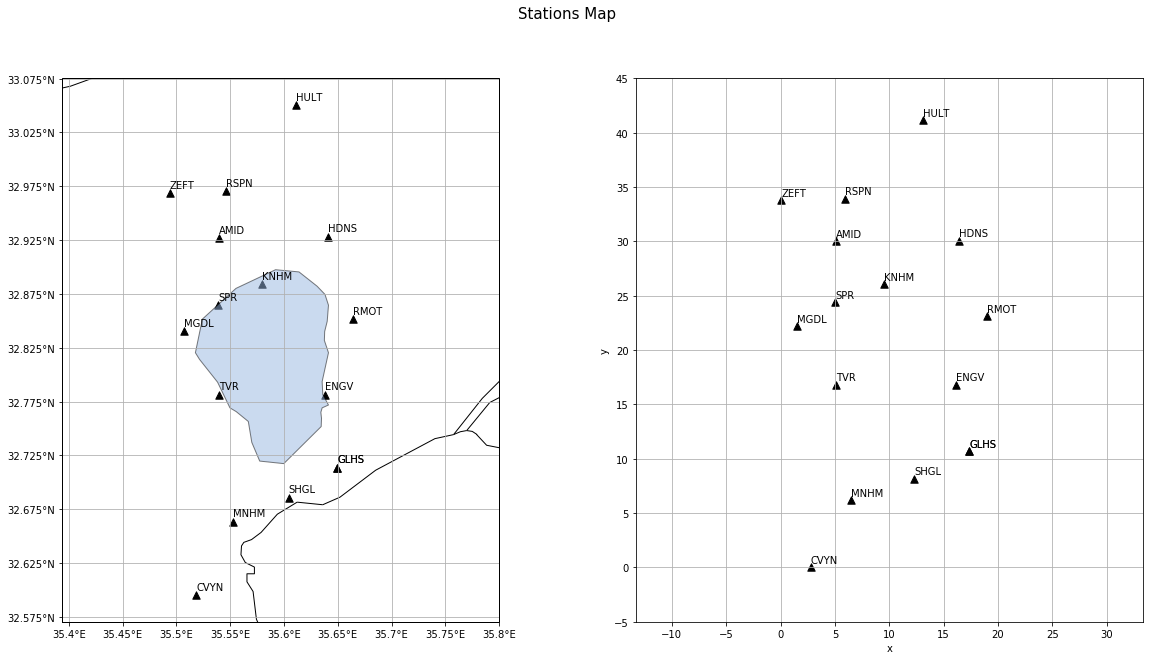

In [132]:
i = 1 
(events_dfs[i]["y"], events_dfs[i]["x"]), diff = conversite(events_dfs[i]["lon"], events_dfs[i]["lat"], grid_size=100)

fig = plt.figure(figsize = (20, 10))
fig.suptitle('Stations Map', fontsize=15)

projection = ccrs.PlateCarree()
ax = fig.add_subplot(1, 2 ,1, projection = projection)
ax1 = fig.add_subplot(1, 2 ,2)
ax.set_extent([events_dfs[i]["lon"].min() - 0.1,
               events_dfs[i]["lon"].max() + 0.1,
               events_dfs[i]["lat"].min() - 0.025,
               events_dfs[i]["lat"].max() + 0.025])

ax.add_feature(cfeat.OCEAN.with_scale('10m'), edgecolor='k', facecolor=(0,0.85,1))
ax.add_feature(cfeat.LAND.with_scale('10m'), edgecolor='k', alpha = 0.0, facecolor='w')
ax.add_feature(cfeat.COASTLINE.with_scale('10m'), edgecolor='k')
ax.add_feature(cfeat.BORDERS.with_scale('10m'), edgecolor='k')
# ax.add_feature(cfeat.RIVERS.with_scale('10m'), edgecolor='b', alpha = 0.5)
ax.add_feature(cfeat.LAKES.with_scale('10m'), edgecolor='k', alpha = 0.5)

ax.grid(True)
ax.set_xticks(np.arange(events_dfs[i]["lon"].min().round(1) - 0.1, events_dfs[i]["lon"].max().round(1) + 0.1, 0.05),
              crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(events_dfs[i]["lat"].min().round(1) - 0.025, events_dfs[i]["lat"].max().round(1) + 0.025, 0.05), 
              crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
# ax.set_title('Stations Map', fontsize=15)

ax.scatter(events_dfs[i]["lon"], events_dfs[i]["lat"], marker='^', s=55, c='k')
for station in events_dfs[i].iterrows():
    ax.text(station[1]["lon"], station[1]["lat"] + 0.005, station[0][0])
    ax1.text(station[1]["x"], station[1]["y"] + 0.4, station[0][0])
    
ax1.set_xlim(-8, events_dfs[i]["x"].max() + 8)
ax1.set_ylim(-8, events_dfs[i]["y"].max() + 8)

ax1.scatter(events_dfs[i]["x"], events_dfs[i]["y"], marker='^', s=55, c='k')
ax1.axis('equal')
ax1.grid(True)
marg_x, marg_y = 2, 1
ax1.set_xticks(np.arange(-(5 * marg_x), (np.ceil(events_dfs[i]["x"].max()) // 5 + marg_x + 1) * 5, 5))
ax1.set_yticks(np.arange(-(5 * marg_y), (np.ceil(events_dfs[i]["y"].max()) // 5 + marg_y + 1) * 5, 5))
ax1.set_xlabel('x')
ax1.set_ylabel('y')

In [138]:
j = 1 

c = []
i = []

depth=5
vp=2
events_dfs[j].loc["tp", s1]
# events_dfs[j]["tp"] = map(UTCDateTime, events_dfs[j]["tp"])

# for s1 in range(len(events_dfs[j])):
#     for s2 in range(s1 + 1, len(events_dfs[j])):
#         i+=[[s1,s2]]
#         c+=[UTCDateTime(events_dfs[j].loc[s1, "tp"]) - UTCDateTime(events_dfs[j].loc[s2, "tp"])]
# print(i)
# aoc=len(c)   

KeyError: 'tp'

In [99]:
       
for y in range(wy):
    for x in range(wx):

        gx= x*delta
        gy= y*delta

        tt= [0 for i in range(aos)]
        for s in range(aos):      
            tt[s]= np.sqrt( (px[s]-gx)**2 + (py[s]-gy)**2 + (0-depth)**2) / vp
            
        rSum=0
        for ci in range(aoc): 

            #CONSTRAINTS (ci): thickness of constraints
            #if np.abs((tt[i[ci][0]] - tt[i[ci][1]]) - c[ci]) < 0.1: rSum+=1
            #RESIDUA
            rSum+= np.abs((tt[i[ci][0]] - tt[i[ci][1]]) - c[ci]);
            
            
        mrs[y][x]= rSum

-5.0

In [66]:
events_dfs[1]

Unnamed: 0        lat        lon  elevation  local_depth  \
station channel                                                             
ZEFT    EN                0  32.968786  35.493747      803.0          0.0   
MNHM    EN                1  32.663572  35.552345     -132.0          0.0   
RMOT    EN                2  32.851506  35.664467       12.0          0.0   
SPR     EN                3  32.864735  35.538822     -177.0          0.0   
MGDL    EN                4  32.840339  35.507188      -83.0          5.0   
SHGL    EN                5  32.685752  35.604253     -166.0          4.0   
GLHS    HH                6  32.713434  35.649608      356.0          5.0   
        EN                7  32.713434  35.649608      356.0          2.0   
HDNS    EN                8  32.927987  35.641179        0.0          0.0   
HULT    EN                9  33.050382  35.610995      117.0          0.0   
AMID    EN               10  32.927027  35.539343      274.0          6.0   
RSPN    EN               11  32.970412  35.546340      376.0          0.0   
CVYN    EN               12  32.595407  35.518607      323.0          2.0   
ENGV    EN               13  32.781511  35.638451     -172.0          0.0   
KNHM    EN               14  32.883750  35.579223     -174.0          0.0   
TVR     EN               15  32.781325  35.539679     -127.0          0.0   

                 sampling_rate     cat_tp                       cat_ts  \
station channel                                                          
ZEFT    EN               200.0  14.742774                          NaN   
MNHM    EN               200.0  21.085376  2018-07-04T03:57:43.962001Z   
RMOT    EN               200.0   8.836665  2018-07-04T03:57:41.907001Z   
SPR     EN               200.0   3.198161  2018-07-04T03:57:40.972999Z   
MGDL    EN               200.0   6.013520  2018-07-04T03:57:41.404998Z   
SHGL    EN               200.0  18.831541  2018-07-04T03:57:43.803001Z   
GLHS    HH               200.0  17.178395  2018-07-04T03:57:43.540000Z   
        EN               200.0  17.178395  2018-07-04T03:57:43.540000Z   
HDNS    EN               200.0  10.702757  2018-07-04T03:57:42.277000Z   
HULT    EN               200.0  22.322000                          NaN   
AMID    EN               200.0   8.750839  2018-07-04T03:57:41.901000Z   
RSPN    EN               200.0  13.280581                          NaN   
CVYN    EN               200.0  29.000506                          NaN   
ENGV    EN               200.0  10.177882  2018-07-04T03:57:42.333000Z   
KNHM    EN               200.0   3.569524  2018-07-04T03:57:40.973999Z   
TVR     EN               200.0   8.415273  2018-07-04T03:57:41.694000Z   

                                cat_distance                   tp_sta_lta  \
station channel                                                             
ZEFT    EN                               NaN  2018-07-08T18:36:57.545000Z   
MNHM    EN       2018-07-04T03:57:48.179000Z  2018-07-08T18:36:55.995000Z   
RMOT    EN       2018-07-04T03:57:43.936000Z  2018-07-08T18:36:53.700000Z   
SPR     EN       2018-07-04T03:57:42.291999Z  2018-07-08T18:36:52.650000Z   
MGDL    EN       2018-07-04T03:57:43.112998Z  2018-07-08T18:36:53.225000Z   
SHGL    EN       2018-07-04T03:57:47.228000Z  2018-07-08T18:36:56.455000Z   
GLHS    HH       2018-07-04T03:57:46.945999Z  2018-07-08T18:36:55.465000Z   
        EN       2018-07-04T03:57:46.945999Z  2018-07-08T18:36:55.465000Z   
HDNS    EN       2018-07-04T03:57:45.029998Z  2018-07-08T18:36:53.990000Z   
HULT    EN                               NaN  2018-07-08T18:36:56.050000Z   
AMID    EN       2018-07-04T03:57:44.208000Z  2018-07-08T18:36:53.475000Z   
RSPN    EN                               NaN  2018-07-08T18:36:54.260000Z   
CVYN    EN                               NaN  2018-07-08T18:36:57.235000Z   
ENGV    EN       2018-07-04T03:57:44.894001Z  2018-07-08T18:36:54.275000Z   
KNHM    EN       2018-07-04T03:57:42.154998Z  2018-07-08T18:36:52

In [122]:
station_cols = ["lat", "lon", "elevation", "local_depth", "sampling_rate"]
stations = df_event[station_cols]
conversite(stations.lat, stations.lon)

TypeError: loop of ufunc does not support argument 0 of type Latitude which has no callable radians method

In [110]:
len(['MLDT', 'CVYN', 'MNHM', 'SHGL', 'ALMT', 'GLHS', 'ENGV', 'TVR', 'MGDL', 'SPR', 'KNHM', 
                'RMOT', 'HDNS', 'AMID', 'ZEFT', 'RSPN', 'KSHO', 'KDZV', 'HULT', 'ZRT'])

20

### for i, st in enumerate(waveforms_raw):
    for j, tr in enumerate(st):
        try:
        #     fig1 = tr.plot()
            tr_d = tr.copy().detrend("linear")
        #     fig2 = tr_d.plot()
            tr_d_f = tr_d.copy().filter("bandpass", freqmin=1, freqmax=10)
        #     fig3 = tr_d_f.plot()
        except Exception as e:
            print(e)
            print(f"event: {i}, trace: {j}")
            print(tr)

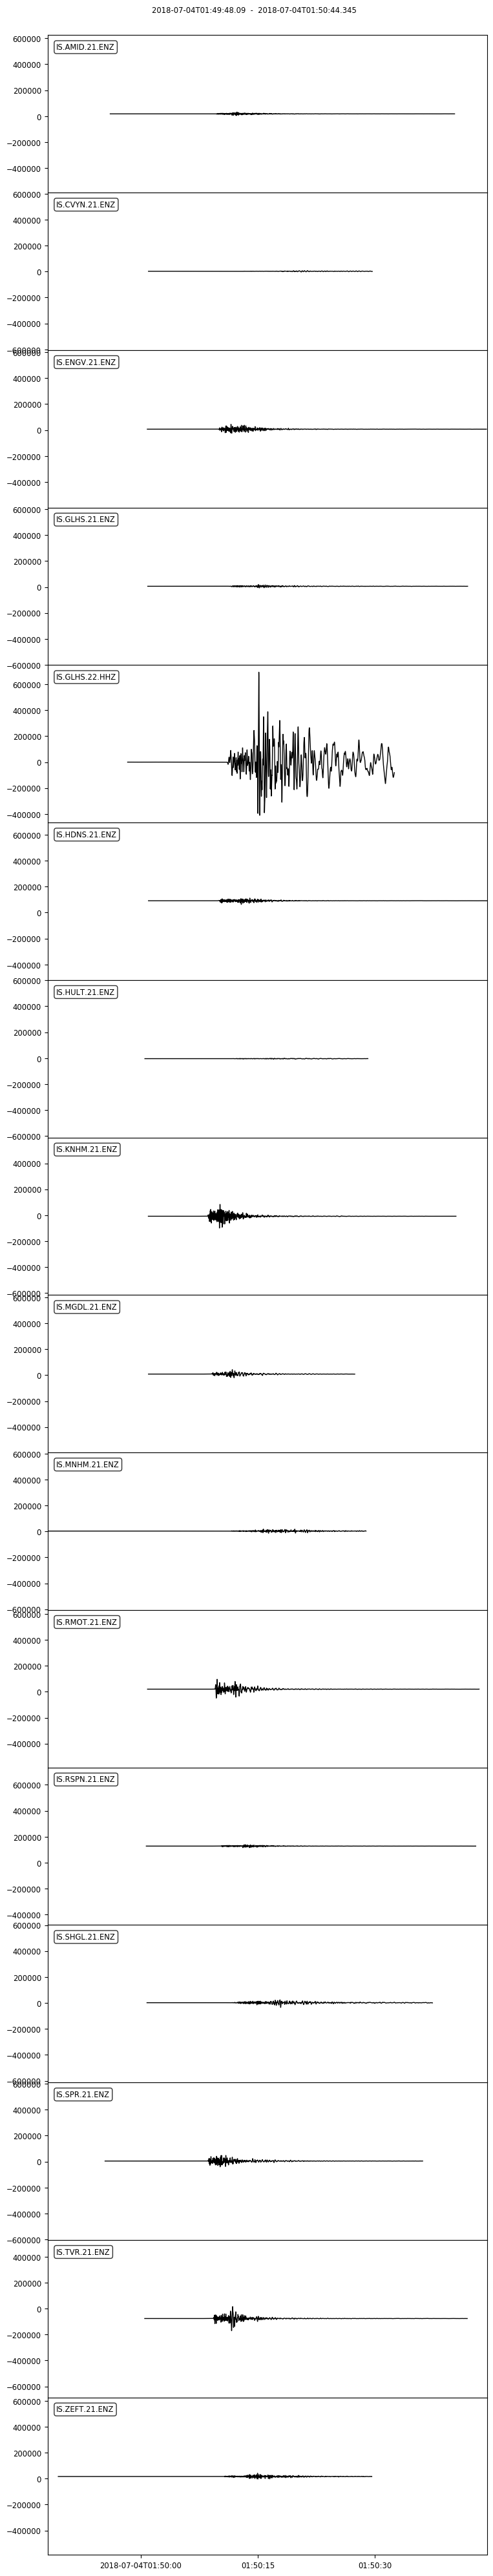

In [42]:
fig = st.copy().select(channel="??Z").plot()